# Load Libraries

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (confusion_matrix, f1_score, classification_report, accuracy_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize 
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters

In [5]:

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
NUM_EPOCHS = 10
IMAGE_SIZE = 150
PATIENCE = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load Dataset

In [6]:

# TensorBoard writer
writer = SummaryWriter(log_dir=os.path.join('runs', 'rps_cnn'))

def compute_mean_std():
    raw_dataset = datasets.ImageFolder(
        root="/kaggle/input/rock-paper-scissor/rock-paper-scissors/train",
        transform=transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor()
        ])
    )
    
    loader = DataLoader(raw_dataset, batch_size=64, shuffle=False, num_workers=2)
    
    mean = 0.0
    std = 0.0
    nb_samples = 0
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
        
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(), std.numpy()

train_mean, train_std = compute_mean_std()

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# Load datasets with correct paths
base_dataset = datasets.ImageFolder(
    root="/kaggle/input/rock-paper-scissor/rock-paper-scissors/train",
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root="/kaggle/input/rock-paper-scissor/rock-paper-scissors/test",
    transform=test_transform
)

# Create stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(
    np.zeros(len(base_dataset)),  # Dummy data
    base_dataset.targets          # Use actual class labels for stratification
))

train_dataset = Subset(base_dataset, train_idx)
val_dataset = Subset(base_dataset, val_idx)



# Display Dataset

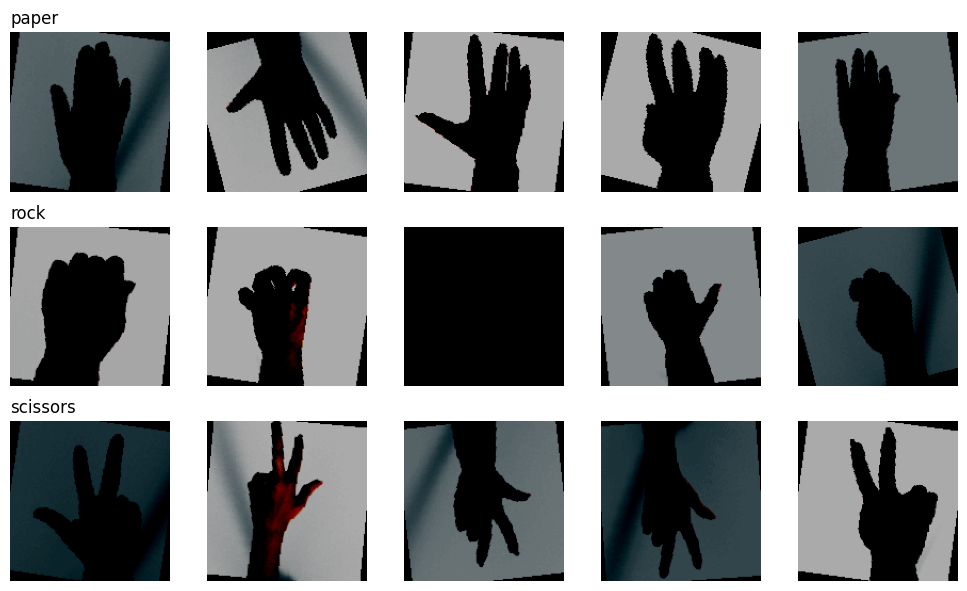

In [16]:

num_images_per_class = 5
class_to_images = {class_name: [] for class_name in base_dataset.classes}

for img, label in train_dataset:
    if len(class_to_images[base_dataset.classes[label]]) < num_images_per_class:
        class_to_images[base_dataset.classes[label]].append(img)
    if all(len(v) >= num_images_per_class for v in class_to_images.values()):
        break

# Plot images
fig, axes = plt.subplots(len(class_to_images), num_images_per_class, figsize=(num_images_per_class * 2, len(class_to_images) * 2))

for i, (class_name, images) in enumerate(class_to_images.items()):
    for j, img in enumerate(images):
        ax = axes[i, j]
        ax.imshow(img.permute(1, 2, 0)) 
        ax.axis("off")
        if j == 0:
            ax.set_title(class_name, fontsize=12, loc='left')

plt.tight_layout()
plt.show()

# Data Loaders

In [8]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Model

In [9]:

class RockPaperScissorsCNN(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # First conv layer
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),  # Second conv layer
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Third conv layer (newly added)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(32 * 18 * 18, 64),  # Adjusted neurons
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 3)  # Output layer
        )
        
        self.activations = {}
        self._register_hooks()
    
    def _register_hooks(self):
        def get_activation(name):
            def hook(model, input, output):
                self.activations[name] = output.detach()
            return hook
        
        self.network[0].register_forward_hook(get_activation('conv1'))
        self.network[4].register_forward_hook(get_activation('conv2'))
        self.network[8].register_forward_hook(get_activation('conv3'))  # Hook for new layer

    def forward(self, x):
        return self.network(x)

model = RockPaperScissorsCNN(DROPOUT_RATE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# Log model graph
sample_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
writer.add_graph(model, sample_input)


# Training

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
Train Loss: 0.8954 | Val Loss: 0.4633
Val Acc: 0.8155 | Val F1: 0.8184
--------------------------------------------------
Epoch 2/10
Train Loss: 0.3374 | Val Loss: 0.1822
Val Acc: 0.9425 | Val F1: 0.9423
--------------------------------------------------
Epoch 3/10
Train Loss: 0.1772 | Val Loss: 0.1814
Val Acc: 0.9425 | Val F1: 0.9423
--------------------------------------------------
Epoch 4/10
Train Loss: 0.1328 | Val Loss: 0.1111
Val Acc: 0.9742 | Val F1: 0.9742
--------------------------------------------------
Epoch 5/10
Train Loss: 0.1103 | Val Loss: 0.0959
Val Acc: 0.9742 | Val F1: 0.9740
--------------------------------------------------
Epoch 6/10
Train Loss: 0.0855 | Val Loss: 0.0699
Val Acc: 0.9821 | Val F1: 0.9822
--------------------------------------------------
Epoch 7/10
Train Loss: 0.0639 | Val Loss: 0.0452
Val Acc: 0.9901 | Val F1: 0.9901
--------------------------------------------------
Epoch 8/10
Train Loss: 0.0483 | Val Loss: 0.0496
Val Acc: 0.9901 | Va

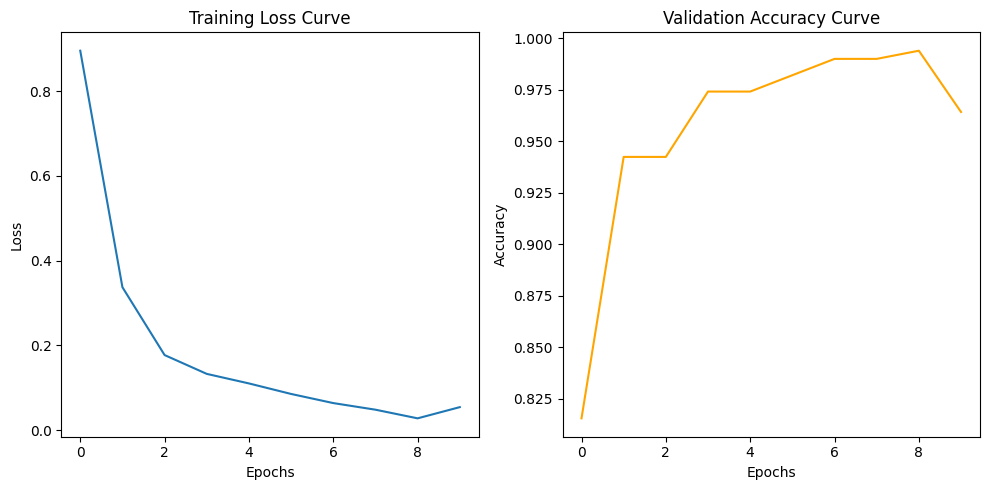

In [10]:


def train_model():
    best_val_loss = np.inf
    epochs_without_improvement = 0
    class_names = base_dataset.classes
    train_losses = []
    val_accuracies = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        writer.add_scalar('Loss/Train', train_loss, epoch)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
        val_accuracies.append(val_acc)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Log metrics
        writer.add_scalar('Loss/Val', val_loss, epoch)
        writer.add_scalar('Accuracy/Val', val_acc, epoch)
        writer.add_scalar('F1/Val', val_f1, epoch)
        
        if epoch % 5 == 0:
            for name, act in model.activations.items():
                writer.add_histogram(f'Activations/{name}', act, epoch)
        
        cm = confusion_matrix(all_labels, all_preds)
        fig = plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                  xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        writer.add_figure('Confusion Matrix', fig, epoch)
        plt.close(fig)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_cnn_model.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
        print('-' * 50)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy', color='orange')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    writer.close()

# Start training
train_model()


# Model Evaluation

<ipython-input-15-08dd8eb4e145>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))


Test Loss: 0.3615
Test Accuracy: 0.8522

Classification Report:
              precision    recall  f1-score   support

       paper       0.80      0.88      0.84       124
        rock       1.00      0.85      0.92       124
    scissors       0.79      0.83      0.81       124

    accuracy                           0.85       372
   macro avg       0.86      0.85      0.85       372
weighted avg       0.86      0.85      0.85       372



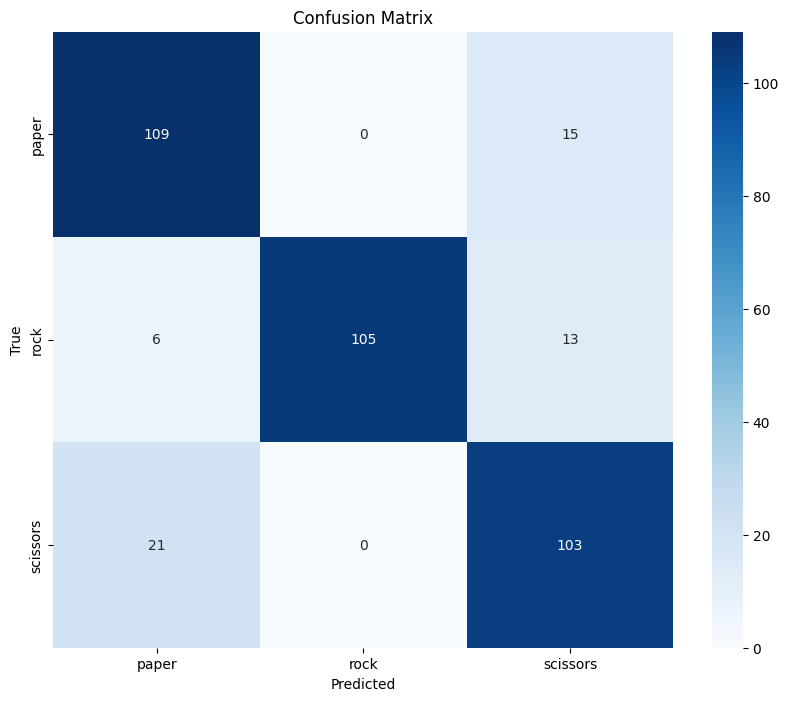

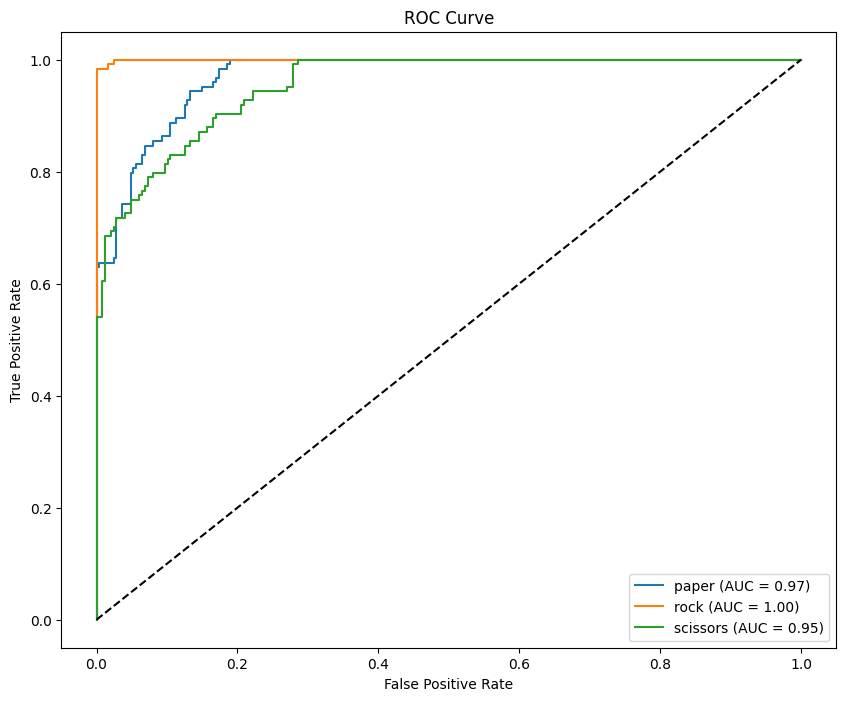

In [15]:

def evaluate_model():
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0.0
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=base_dataset.classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=base_dataset.classes,
                yticklabels=base_dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()
    plt.close()
    
    # ROC Curve
    n_classes = len(base_dataset.classes)
    y_test = label_binarize(all_labels, classes=range(n_classes))  # Now this will work
    
    fig = plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{base_dataset.classes[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.show()
    writer.add_figure('ROC Curve', fig)
    plt.close(fig)

evaluate_model()
writer.close()